In [ ]:
# Importación de bibliotecas necesarias
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import pandas as pd

# Exploración de datos

In [ ]:
# Carga de datos
ruta="/content/drive/MyDrive/WPT_Cordoba_E2025_PCA_2024-12-15_2025-04-20.shp"

In [ ]:
capa = gpd.read_file(ruta)
misdatos=capa.to_crs(epsg='32720').copy()
misdatos.info()

In [ ]:
# Try reading with a different encoding
try:
    capa = gpd.read_file(ruta, encoding='latin-1')
except UnicodeDecodeError:
    # If latin-1 fails, try another common encoding like cp1252
    capa = gpd.read_file(ruta, encoding='cp1252')

misdatos=capa.to_crs(epsg='32720').copy()
misdatos.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10147 entries, 0 to 10146
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_depto    10140 non-null  object  
 1   OBSERVACIO  21 non-null     object  
 2   landcover   10147 non-null  int32   
 3   depto       10140 non-null  object  
 4   pc1         10147 non-null  float64 
 5   geometry    10147 non-null  geometry
dtypes: float64(1), geometry(1), int32(1), object(3)
memory usage: 436.1+ KB


In [ ]:
print(misdatos['pc1'].describe())

count    10147.000000
mean         0.884397
std          0.746926
min         -2.645888
25%          0.356350
50%          1.019815
75%          1.436013
max          2.998792
Name: pc1, dtype: float64


In [ ]:
print(misdatos[['landcover', 'pc1']].isnull().sum())

landcover    0
pc1          0
dtype: int64


In [ ]:
print(misdatos[['landcover', 'pc1']].isna().sum())

landcover    0
pc1          0
dtype: int64


In [ ]:
print(np.isinf(misdatos['pc1']).any())  # Verifica si hay algún valor infinito

False


<ipython-input-12-ef8f83db7d7f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='landcover', data=misdatos, order=misdatos['landcover'].value_counts().index, palette='Set2')


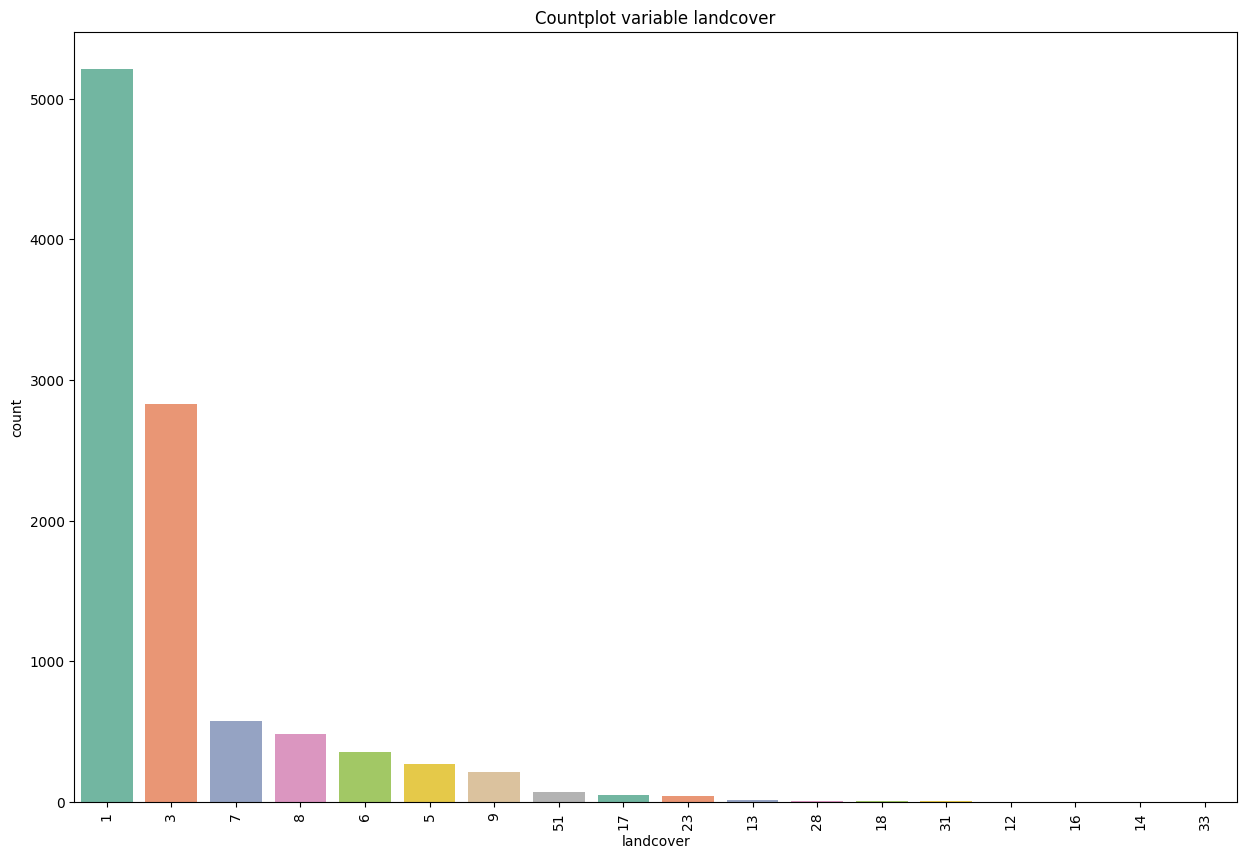

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes()
ax = sns.countplot(x='landcover', data=misdatos, order=misdatos['landcover'].value_counts().index, palette='Set2')
plt.xticks(rotation=90)
plt.title("Countplot variable landcover")
plt.show()

<ipython-input-17-7ef3a0c48ba1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='landcover', data=misdatos, order=misdatos['landcover'].value_counts().index, palette='Set2')


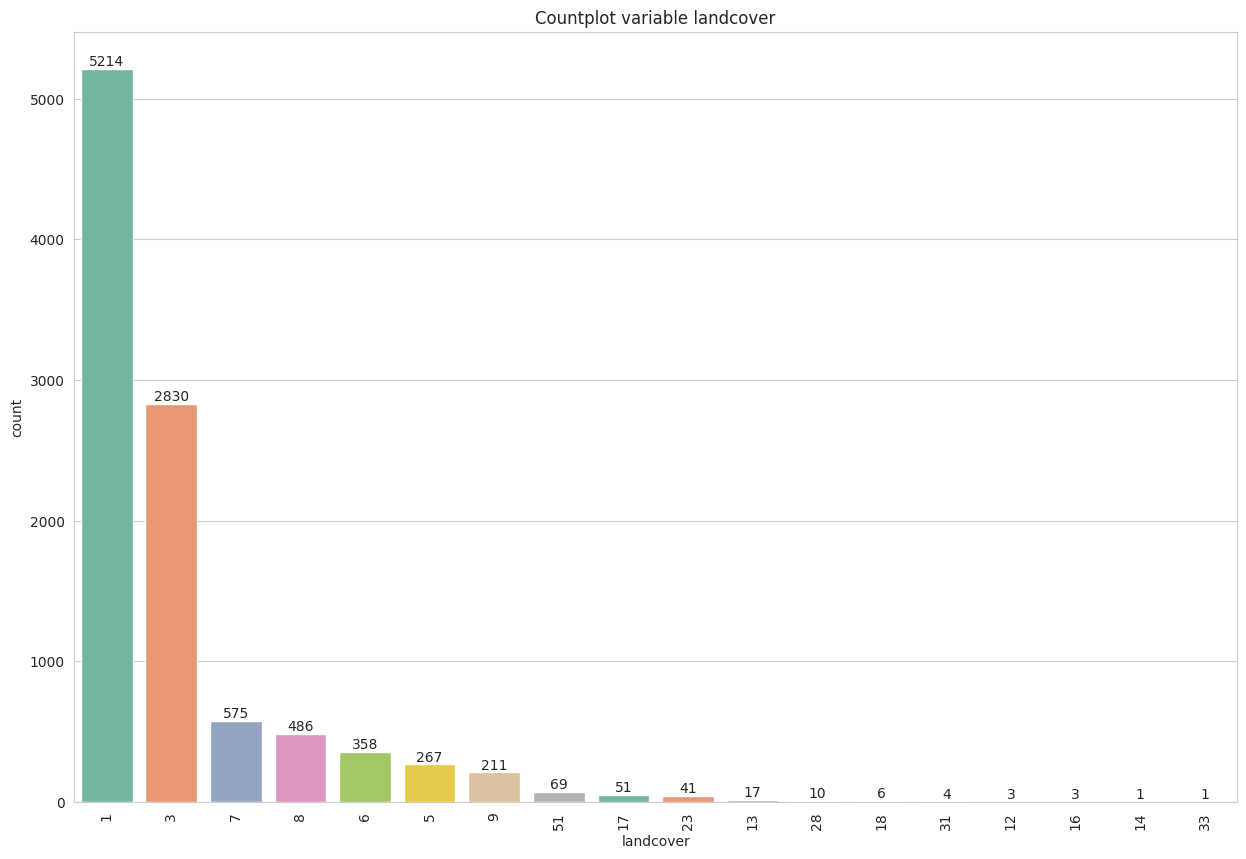

In [ ]:
def annotate_bars(ax):
    for p in ax.patches:
        height = int(p.get_height())  # convertir a entero
        ax.text(p.get_x() + p.get_width() / 2, height + 1,
                f'{height}', ha='center', va='bottom', fontsize=10)


fig = plt.figure(figsize=(15,10))
ax = sns.countplot(x='landcover', data=misdatos, order=misdatos['landcover'].value_counts().index, palette='Set2')
plt.xticks(rotation=90)
plt.title("Countplot variable landcover")
annotate_bars(ax)
plt.show()

## Análisis agrupado

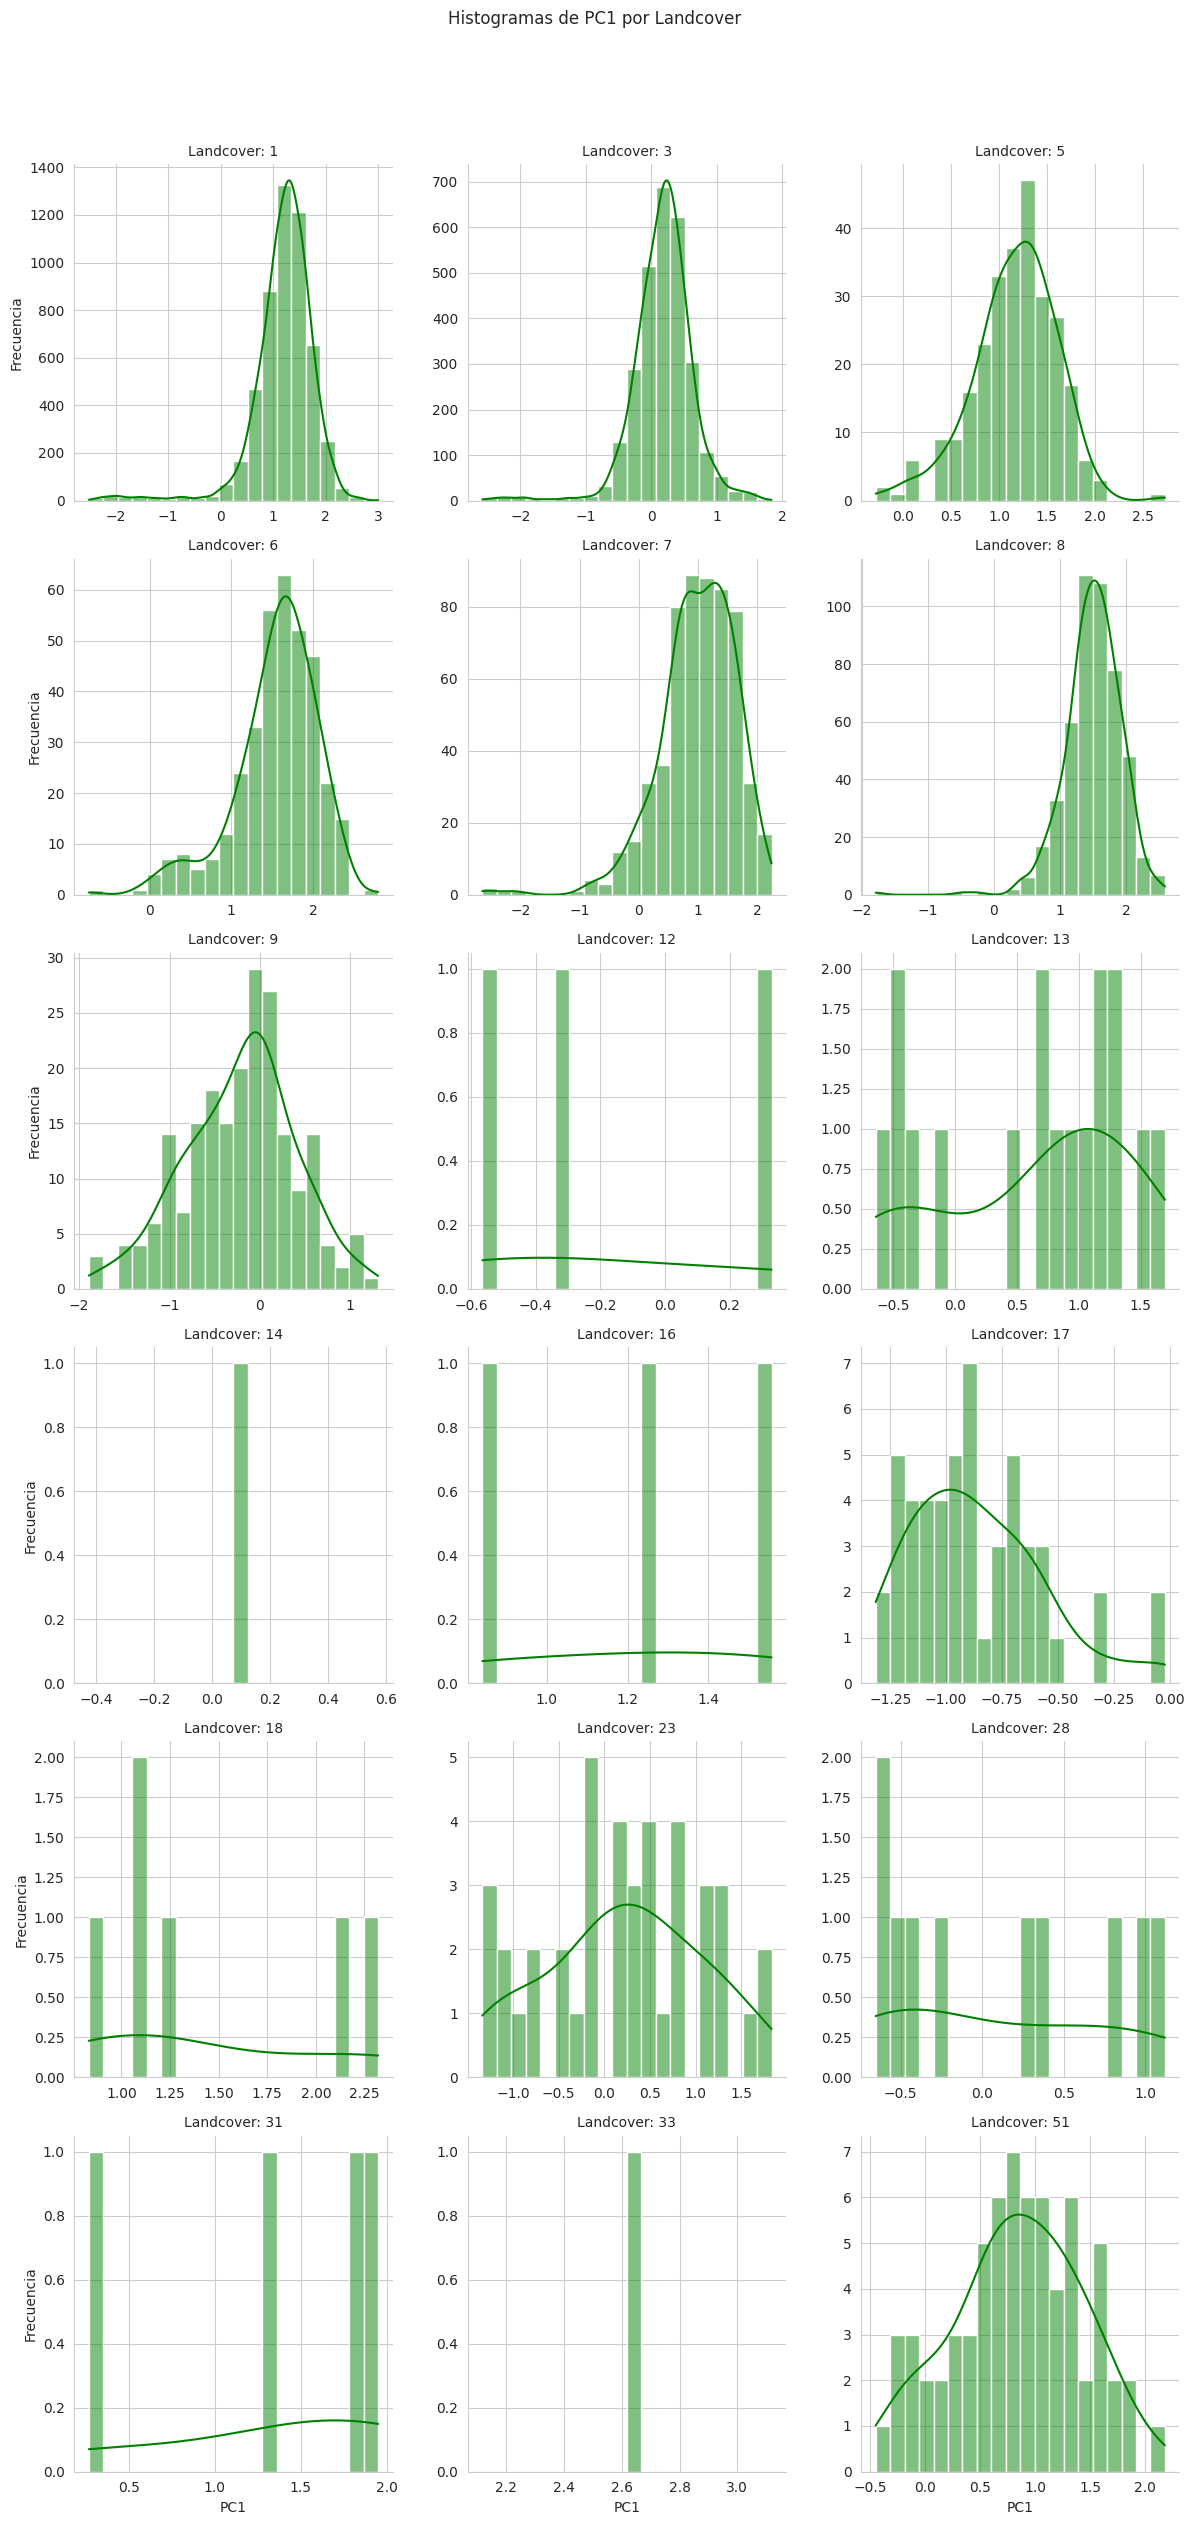

In [ ]:
# Crear FacetGrid para separar por landcover
g = sns.FacetGrid(misdatos, col="landcover", col_wrap=3, height=4, sharex=False, sharey=False)
#g = sns.FacetGrid(misdatos, col="landcover")
# Generar un histograma para cada categoría de landcover
g.map(sns.histplot, "pc1", bins=20, color="green", kde=True)

# Añadir títulos generales
g.fig.suptitle("Histogramas de PC1 por Landcover", y=1.05)
g.set_axis_labels("PC1", "Frecuencia")
g.set_titles("Landcover: {col_name}")

# Mostrar gráficos
plt.show()

<ipython-input-19-dab77f5dd10a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="landcover", y="pc1", data=misdatos, palette='viridis',legend=False)


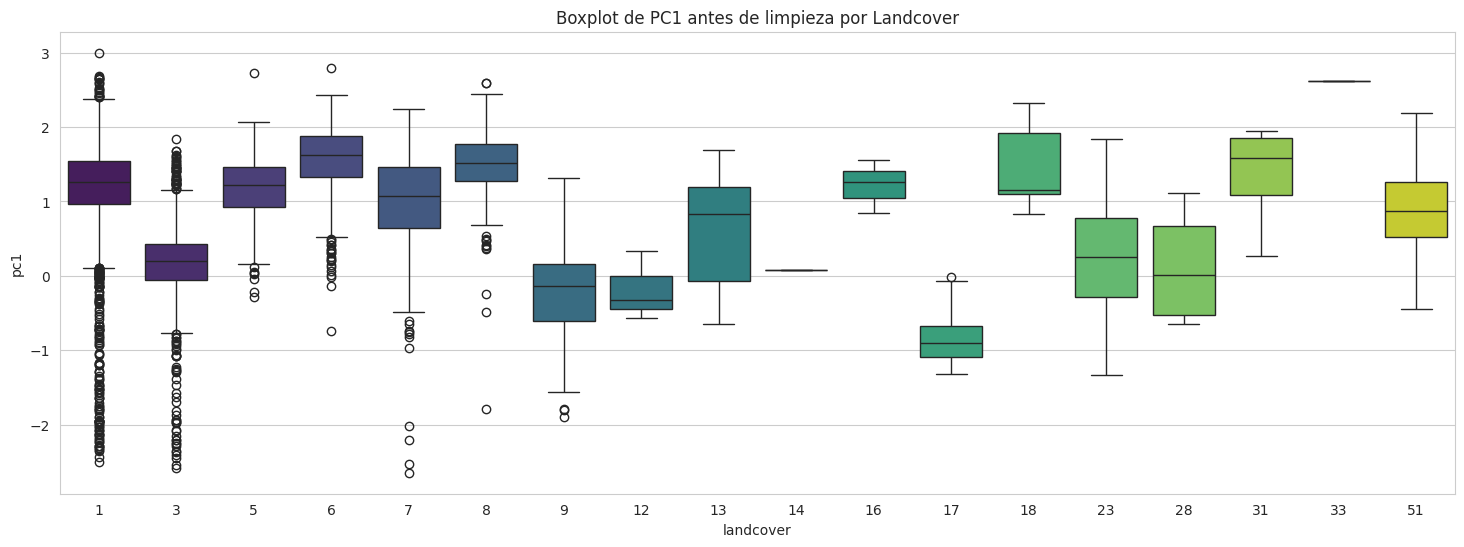

In [ ]:
plt.figure(figsize=(18, 6))
# Using Seaborn to create a swarm plot
sns.boxplot(x="landcover", y="pc1", data=misdatos, palette='viridis',legend=False)
plt.title("Boxplot de PC1 antes de limpieza por Landcover")
plt.show()

In [ ]:
# Filtrar puntos según los valores de 'landcover' que deseas modificar
landcover = [12,13,14,16,17,18,23,28,31,33]  # Especifica los valores que deseas filtrar
puntos_no_modificados = misdatos[misdatos['landcover'].isin(landcover)]
misdatos = misdatos[~misdatos['landcover'].isin(landcover)]
print(f"Cultivo sin analizar: {puntos_no_modificados['landcover'].unique()}")
print(f"Cultivo analizados: {misdatos['landcover'].unique()}")


Cultivo sin analizar: [17 12 13 14 16 18 23 28 33 31]
Cultivo analizados: [ 1  3  6  5 51  7  8  9]


## Limpieza de datos agrupados

In [ ]:
# Función para limpiar datos (eliminar outliers) dentro de un grupo
def limpiar_outliers(grupo, columna, factor=3):
    # Calcular estadísticas específicas para el grupo
    media = np.mean(grupo[columna])
    desvio = np.std(grupo[columna])
    li = media - factor * desvio  # Límite inferior
    ls = media + factor * desvio  # Límite superior

    # Filtrar datos dentro de los límites
    grupo_filtrado = grupo[(grupo[columna] > li) & (grupo[columna] < ls)]

    # Mostrar estadísticas por grupo
    print(f"Landcover: {grupo['landcover'].iloc[0]} | Media: {media:.2f} | LI: {li:.2f} | LS: {ls:.2f} | Filtrados: {len(grupo) - len(grupo_filtrado)}")
    return grupo_filtrado

# Filtrar y limpiar datos por cada valor de 'landcover'
columna_variable = 'pc1'  # Columna sobre la que trabajamos
datos_limpios = misdatos.groupby('landcover', group_keys=False).apply(limpiar_outliers, columna=columna_variable)

# Resultados finales
print(f"Datos originales: {len(misdatos)}")
print(f"Datos después de limpieza: {len(datos_limpios)}")

Landcover: 1 | Media: 1.20 | LI: -0.53 | LS: 2.93 | Filtrados: 94
Landcover: 3 | Media: 0.18 | LI: -1.15 | LS: 1.52 | Filtrados: 41
Landcover: 5 | Media: 1.17 | LI: -0.13 | LS: 2.47 | Filtrados: 3
Landcover: 6 | Media: 1.54 | LI: 0.01 | LS: 3.07 | Filtrados: 4
Landcover: 7 | Media: 1.00 | LI: -0.95 | LS: 2.95 | Filtrados: 5
Landcover: 8 | Media: 1.50 | LI: 0.21 | LS: 2.79 | Filtrados: 3
Landcover: 9 | Media: -0.22 | LI: -2.05 | LS: 1.61 | Filtrados: 0
Landcover: 51 | Media: 0.84 | LI: -0.91 | LS: 2.60 | Filtrados: 0
Datos originales: 10010
Datos después de limpieza: 9860


<ipython-input-22-0e80188dc9b6>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  datos_limpios = misdatos.groupby('landcover', group_keys=False).apply(limpiar_outliers, columna=columna_variable)


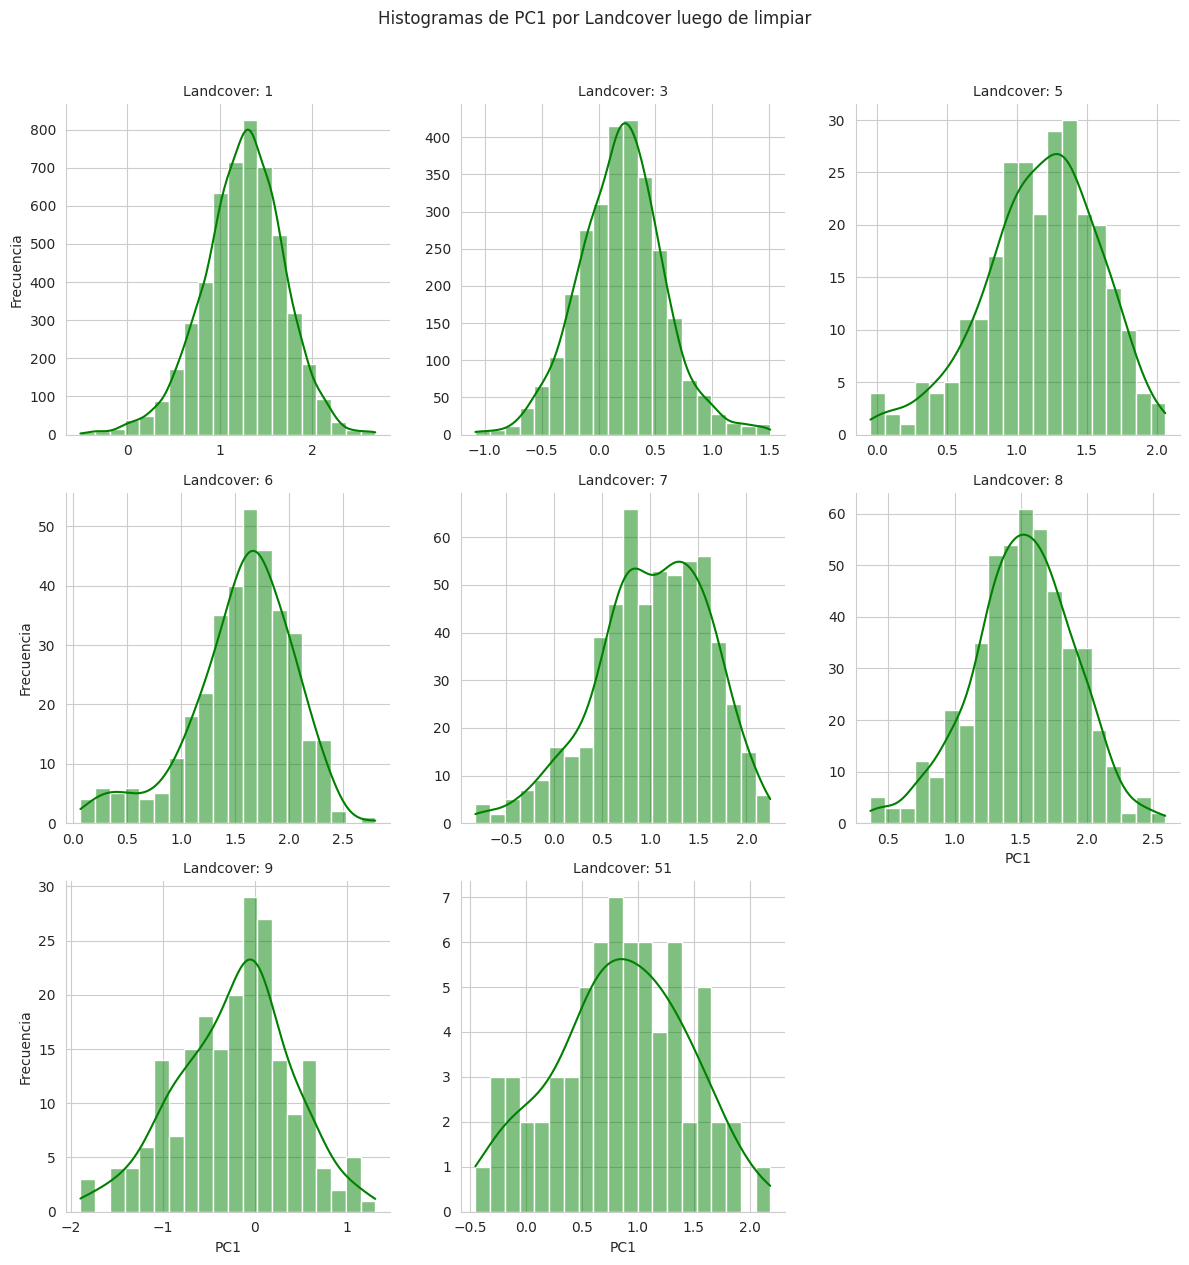

In [ ]:
# Crear FacetGrid para separar por landcover
g = sns.FacetGrid(datos_limpios, col="landcover", col_wrap=3, height=4, sharex=False, sharey=False)
#g = sns.FacetGrid(misdatos, col="landcover")
# Generar un histograma para cada categoría de landcover
g.map(sns.histplot, "pc1", bins=20, color="green", kde=True)

# Añadir títulos generales
g.fig.suptitle("Histogramas de PC1 por Landcover luego de limpiar", y=1.05)
g.set_axis_labels("PC1", "Frecuencia")
g.set_titles("Landcover: {col_name}")

# Mostrar gráficos
plt.show()

<ipython-input-24-2d799bff152d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="landcover", y="pc1", data=datos_limpios, palette="Set2")


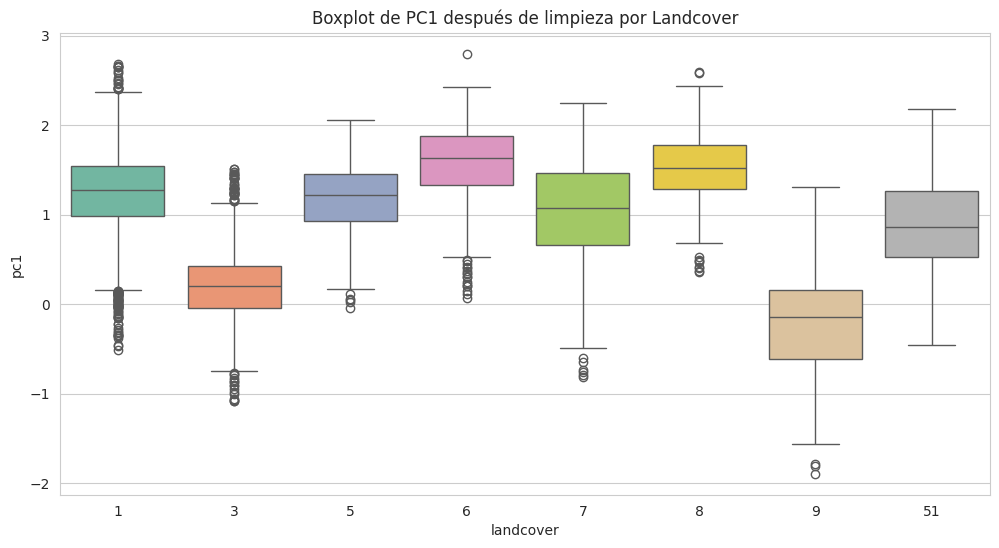

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x="landcover", y="pc1", data=datos_limpios, palette="Set2")
plt.title("Boxplot de PC1 después de limpieza por Landcover")
plt.show()


In [ ]:
# Guardar en un nuevo archivo
# Combinar los puntos modificados y no modificados en una sola capa
datos_limpios = pd.concat([datos_limpios, puntos_no_modificados])
datos_limpios.to_file(f'WPT_Cordoba_E2024_limpios.gpkg', driver='GPKG')

## Análisis por cobertura particular

In [ ]:
print(misdatos['landcover'].unique())
misdatos_copia=capa.copy()

[ 3 25  7 44 77 13 28  9 12 22 14 17 31]


In [ ]:
filtro = 77
datos_filtrados = misdatos_copia[misdatos_copia['landcover'] == filtro]
print(datos_filtrados['landcover'].unique())


[77]


In [ ]:
# Función para cálculo de coeficiente de asimetría
def myskewness(x):
    m3 = np.mean((x - np.mean(x)) ** 3)
    return m3 / (np.std(x) ** 3)

# Media, mediana y coeficiente de asimetría antes de eliminar outliers
Media = np.mean(datos_filtrados['pc1'])
Mediana = np.median(datos_filtrados['pc1'])
Asimetria = myskewness(datos_filtrados['pc1'])
print("Media:", Media)
print("Mediana:", Mediana)
print("Asimetría:", Asimetria)

Media: -0.00011203325695452355
Mediana: 0.141394769616349
Asimetría: -0.6064376006135689


In [ ]:
# Cálculo de límites inferior y superior (LI y LS) para eliminar outliers
Media_dep1 = np.mean(datos_filtrados['pc1'])
DE = np.std(datos_filtrados['pc1'])
LI = Media_dep1 - 2.5 * DE
LS = Media_dep1 + 2.5 * DE
print("Límite Inferior (LI):", LI)
print("Límite Superior (LS):", LS)

Límite Inferior (LI): -2.2115454085354727
Límite Superior (LS): 2.2113213420215634


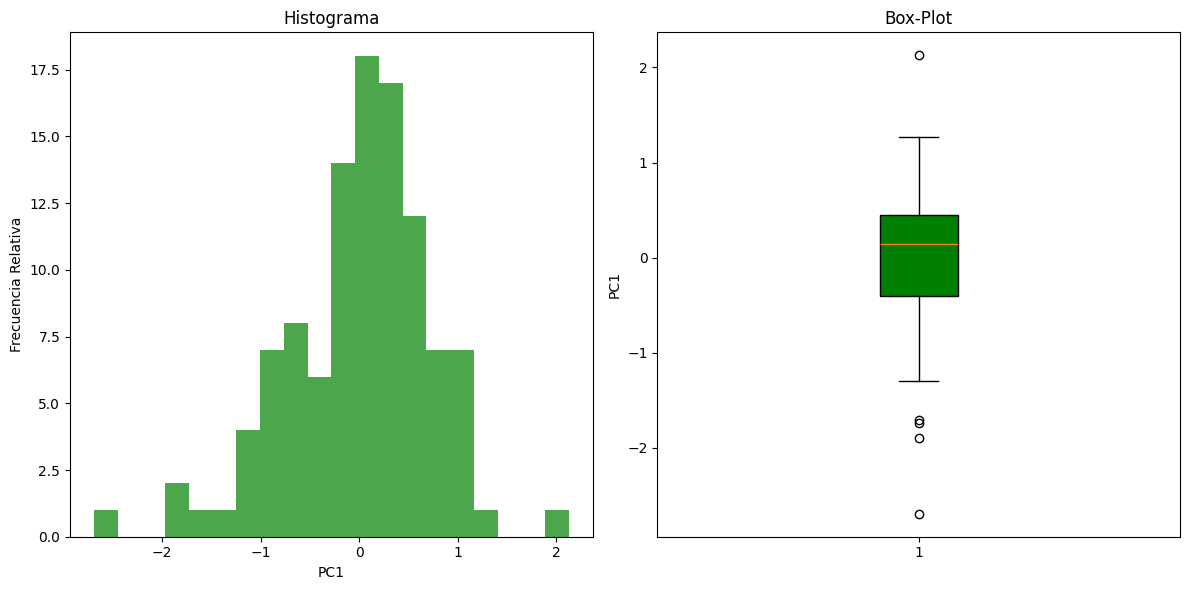

In [ ]:
# Histograma y boxplot antes de eliminar outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(datos_filtrados['pc1'], bins=20, color='green', alpha=0.7)
plt.title("Histograma")
plt.xlabel("PC1")
plt.ylabel("Frecuencia Relativa")

plt.subplot(1, 2, 2)
plt.boxplot(datos_filtrados['pc1'], patch_artist=True, boxprops=dict(facecolor='green'))
plt.title("Box-Plot")
plt.ylabel("PC1")

plt.tight_layout()
plt.show()

## Limpieza de datos por cobertura

In [ ]:
# Eliminación de valores fuera de un rango específico
#misdatos_dep1 = misdatos[(misdatos['REND'] < 8) & (misdatos['REND'] > 0.05)]

misdatos_dep2 = datos_filtrados[(datos_filtrados['pc1'] > LI) & (datos_filtrados['pc1'] < LS)]

# Cálculo del número de valores eliminados
valores_eliminados = len(datos_filtrados) - len(misdatos_dep2)
print("Número de valores eliminados:", valores_eliminados)
porcentaje_eliminados = (valores_eliminados / len(datos_filtrados)) * 100
print(f"Porcentaje de valores eliminados: {porcentaje_eliminados:.2f}%")

Número de valores eliminados: 1
Porcentaje de valores eliminados: 0.93%


In [ ]:
# Media, mediana y coeficiente de asimetría después de eliminar outliers
Media_dep2 = np.mean(misdatos_dep2['pc1'])
Mediana_dep2 = np.median(misdatos_dep2['pc1'])
Asimetria_dep2 = myskewness(misdatos_dep2['pc1'])
print("Media (después):", Media_dep2)
print("Mediana (después):", Mediana_dep2)
print("Asimetría (después):", Asimetria_dep2)

Media (después): 0.025288893467670798
Mediana (después): 0.1419221172299075
Asimetría (después): -0.29399926769171997


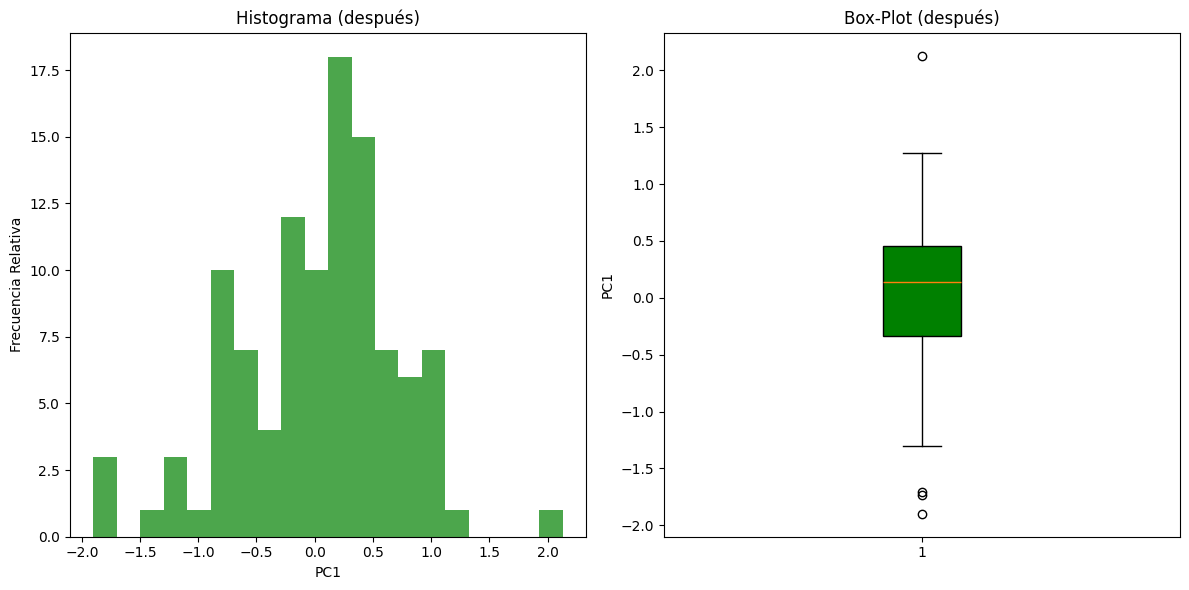

In [ ]:
# Histograma y boxplot después de eliminar outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(misdatos_dep2['pc1'], bins=20, color='green', alpha=0.7)
plt.title("Histograma (después)")
plt.xlabel("PC1")
plt.ylabel("Frecuencia Relativa")

plt.subplot(1, 2, 2)
plt.boxplot(misdatos_dep2['pc1'], patch_artist=True, boxprops=dict(facecolor='green'))
plt.title("Box-Plot (después)")
plt.ylabel("PC1")

plt.tight_layout()
plt.show()